In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from feature_selector import FeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, r2_score, precision_recall_curve, roc_auc_score, roc_curve, auc, f1_score, recall_score
from collections import Counter
from imblearn.under_sampling import NearMiss
import pprint

In [ ]:
pip install feature_selector

In [93]:
missing_values = ["n/a", "na", "--", "NONE", "None", "none", "NA", "N/A"]
fetal_df = pd.read_csv('fetal_health.csv', na_values= missing_values)
fetal_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [94]:
fetal_df.shape

(2126, 22)

In [ ]:
fetal_df.isnull().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [ ]:
fetal_df.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


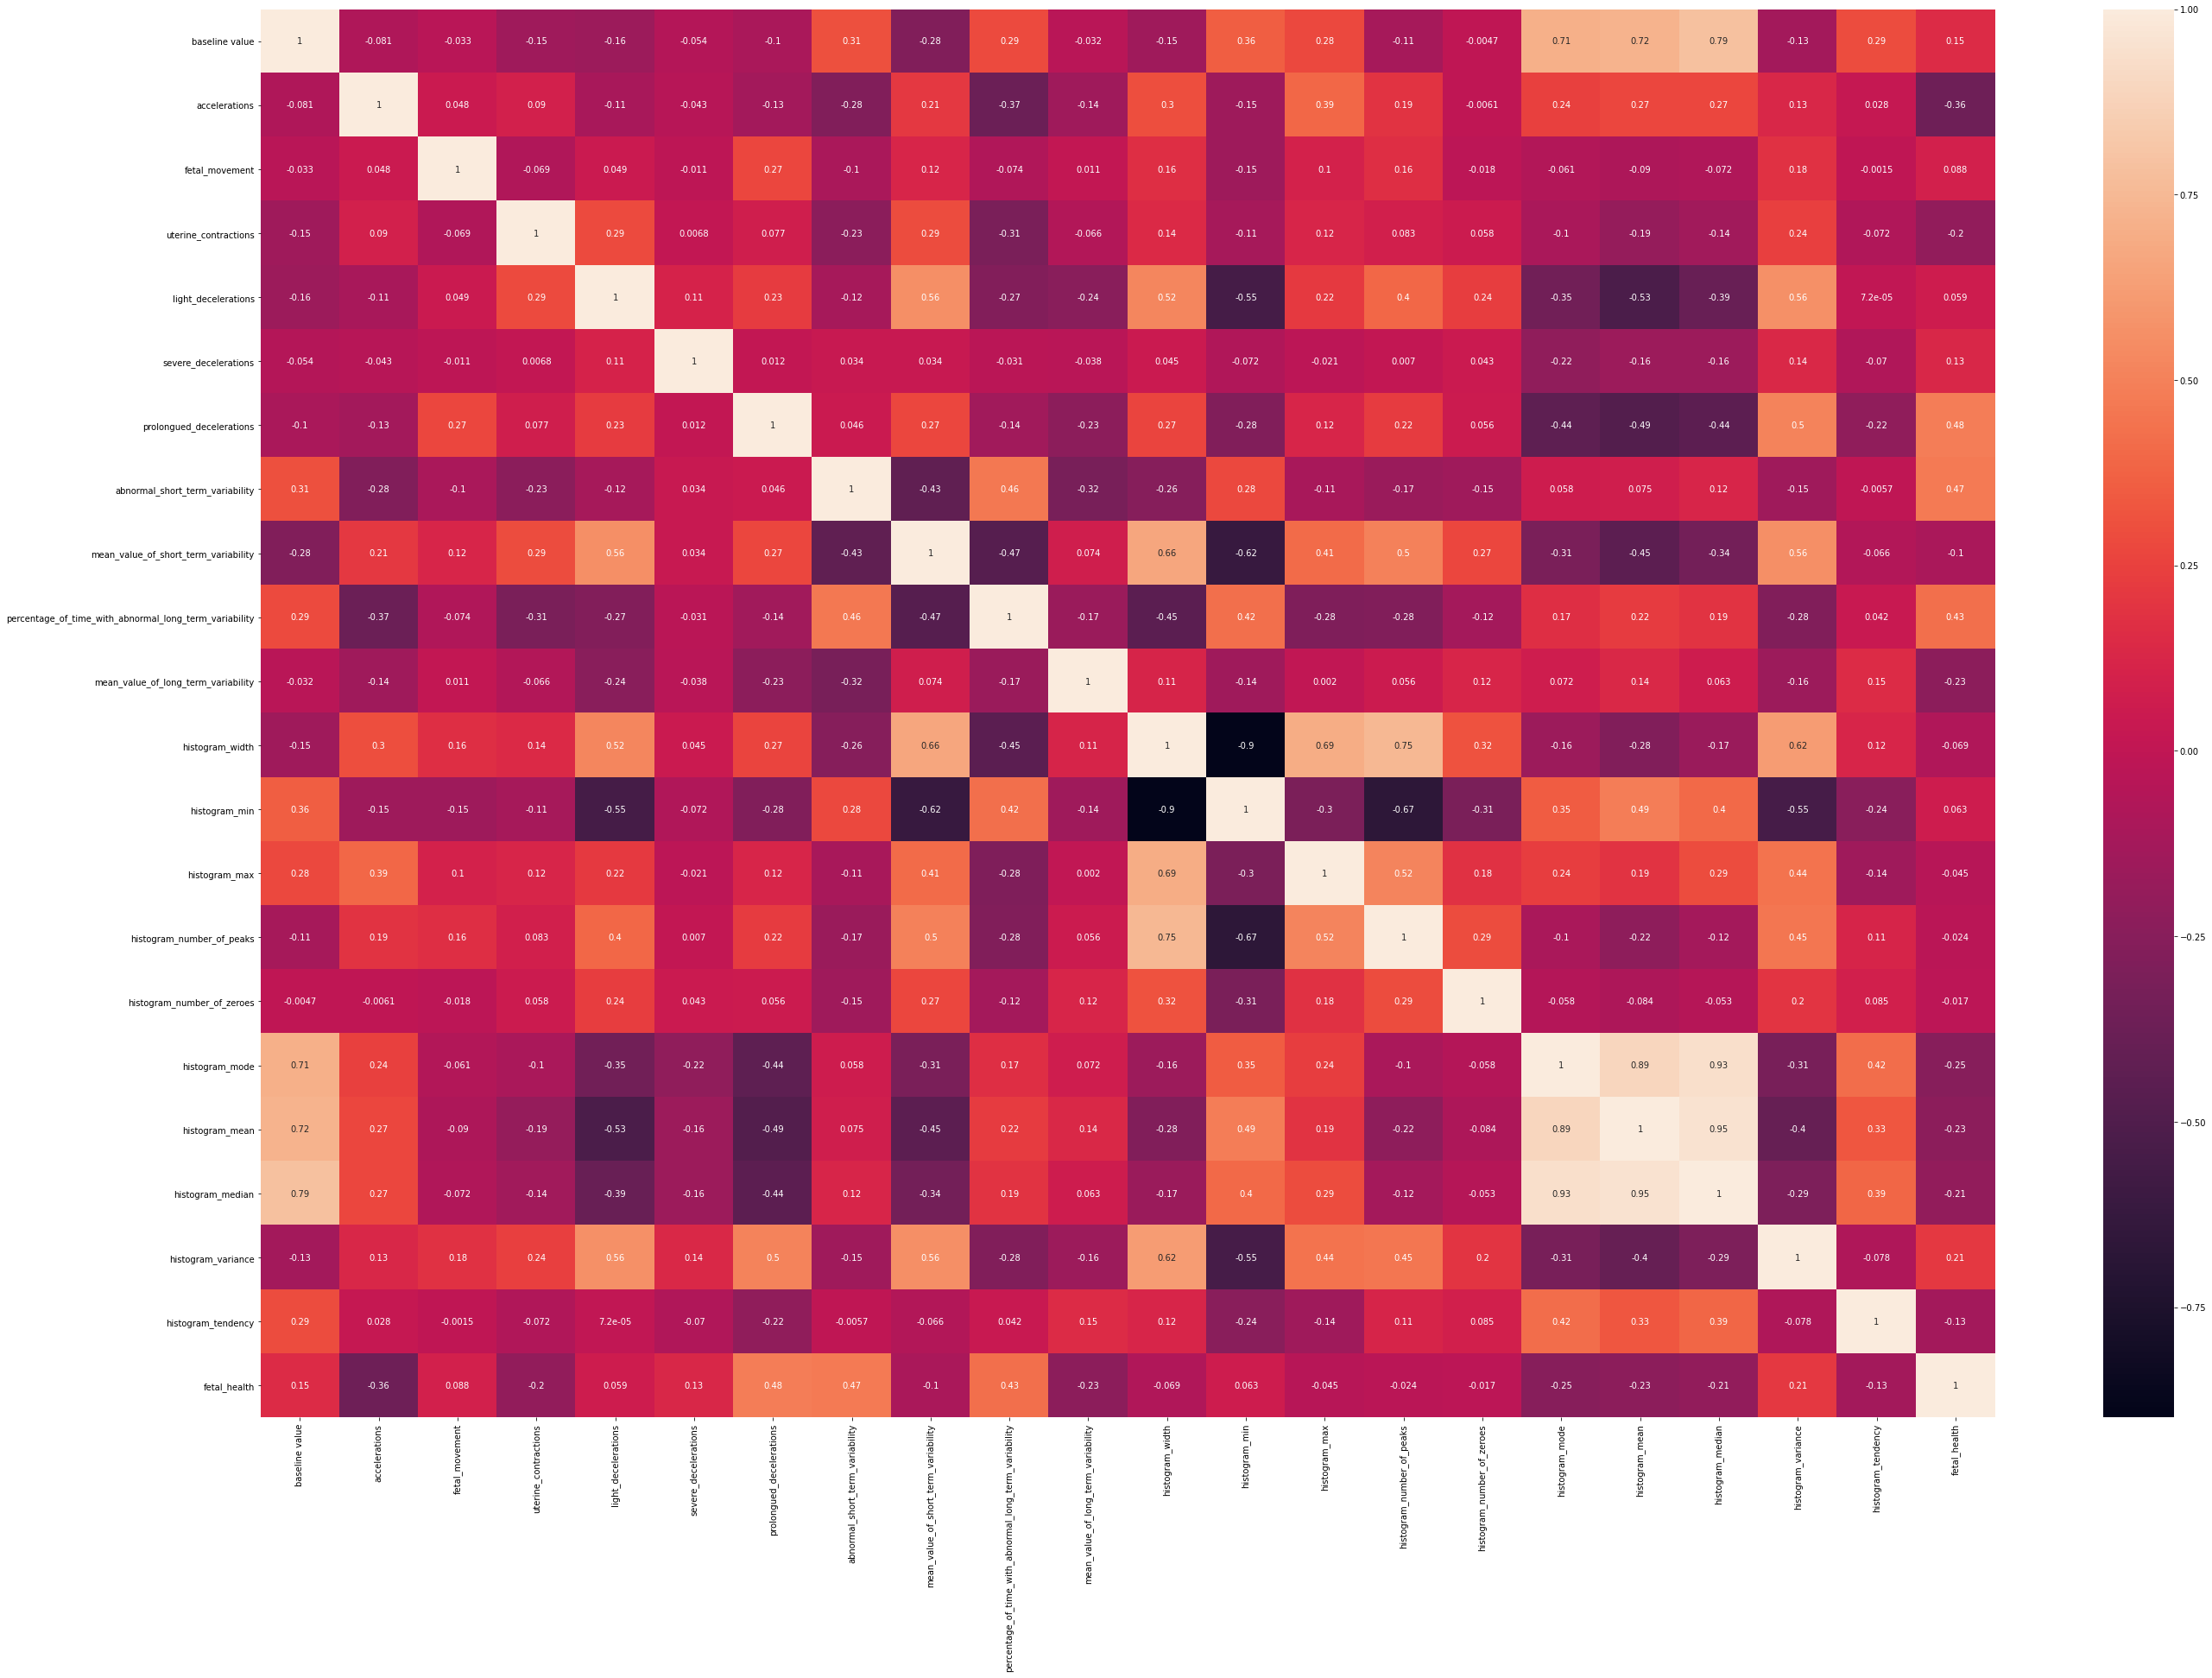

In [ ]:
corr1 = fetal_df.corr()
plt.figure(figsize=(45,30))
heatmap = sns.heatmap(corr1, annot=True)

##Declaring X & y and splitting into train and test

In [95]:
X = fetal_df.drop(['fetal_health'],1)
y = fetal_df['fetal_health']

In [96]:
X_train,X_test,y_train,y_test = tts(X,y,random_state=1,test_size=0.3)

In [97]:
X.shape , y.shape

((2126, 21), (2126,))

##Feature selection using PEARSON CORRELATION

In [98]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [99]:
corr_features = correlation(fetal_df.iloc[:,:21], 0.7)
print("Number of features deleted :",len(set(corr_features)))

Number of features deleted : 4


In [100]:
print("Features deleted are :",corr_features)

Features deleted are : {'histogram_mode', 'histogram_number_of_peaks', 'histogram_mean', 'histogram_median'}


In [101]:
X_train = X_train.drop(corr_features,1)
X_test = X_test.drop(corr_features,1)

In [102]:
X_train.shape , y_train.shape, X_test.shape , y_test.shape

((1488, 17), (1488,), (638, 17), (638,))

##Feature Selection using VARIANCETHRESHOLD  to delete columns with threshold = 0.01

In [103]:
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train,X_test)
print("Remaining featues :",X_train.columns[constant_filter.get_support()]) #This will give the remaining columns which have variance above the passed threshold
print("Remaining total featues :",len(X_train.columns[constant_filter.get_support()]))   # will give total number of remaining columns

Remaining featues : Index(['baseline value', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_zeroes',
       'histogram_variance', 'histogram_tendency'],
      dtype='object')
Remaining total featues : 11


In [104]:
print("Remaining featues :",X_test.columns[constant_filter.get_support()])  #This will give the remaining columns which have variance above the passed threshold
print("Remaining total featues :",len(X_test.columns[constant_filter.get_support()])) # will give total number of remaining columns

Remaining featues : Index(['baseline value', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_zeroes',
       'histogram_variance', 'histogram_tendency'],
      dtype='object')
Remaining total featues : 11


In [105]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[constant_filter.get_support()]]

X_train.drop(labels=constant_columns, axis=1, inplace=True)
X_test.drop(labels=constant_columns, axis=1, inplace=True)

In [106]:
X_train.shape , X_test.shape

((1488, 11), (638, 11))

In [107]:
constant_columns

['accelerations',
 'fetal_movement',
 'uterine_contractions',
 'light_decelerations',
 'severe_decelerations',
 'prolongued_decelerations']

In [108]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((1488, 11), (638, 11), (1488,), (638,))

##Using FeatureSelector library to remove the low importance features
This method relies on a machine learning model to identify features to remove. It therefore requires a supervised learning problem with labels. Cannot be used for unsupervised machine learning.



task = either Classiification or Regression




n_iterations = 10 (default)

early_stopping = Regularization, to stop overfitting


eval_metric = choose metric depending on task either classification or regression 






In [109]:
fs = FeatureSelector(data = X_train, labels = y_train)
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 0.0809131
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[12]	valid_0's auc: 0.0365221
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[15]	valid_0's auc: 0.0567071
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.085977
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 0.098309
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5]	valid_0's auc: 0.0372641
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5]	valid_0's auc: 0.104548
Training until validation scores don't improve for 100 rounds.
Early stopping,

In [110]:
fs.feature_importances.head(11)
# ''' We get the feature importance, its scaled values and than the cummulative sum of importance '''

,feature,importance,normalized_importance,cumulative_importance
0,abnormal_short_term_variability,79.6,0.171220,0.171220
1,mean_value_of_long_term_variability,75.0,0.161325,0.332545
2,percentage_of_time_with_abnormal_long_term_var...,65.4,0.140675,0.473220
3,histogram_variance,51.1,0.109916,0.583136
4,histogram_max,50.3,0.108195,0.691331
5,histogram_min,40.1,0.086255,0.777587
6,baseline value,35.6,0.076576,0.854162
7,mean_value_of_short_term_variability,34.6,0.074425,0.928587
8,histogram_width,25.0,0.053775,0.982362
9,histogram_number_of_zeroes,5.5,0.011831,0.994192


In [111]:
one_hot_features = fs.one_hot_features                     # this store the one hot encoded features formed by the feature_selector library
base_features = fs.base_features                           #base_feature store the original features without one hot encoded one's
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 11 original features
There are 0 one-hot features


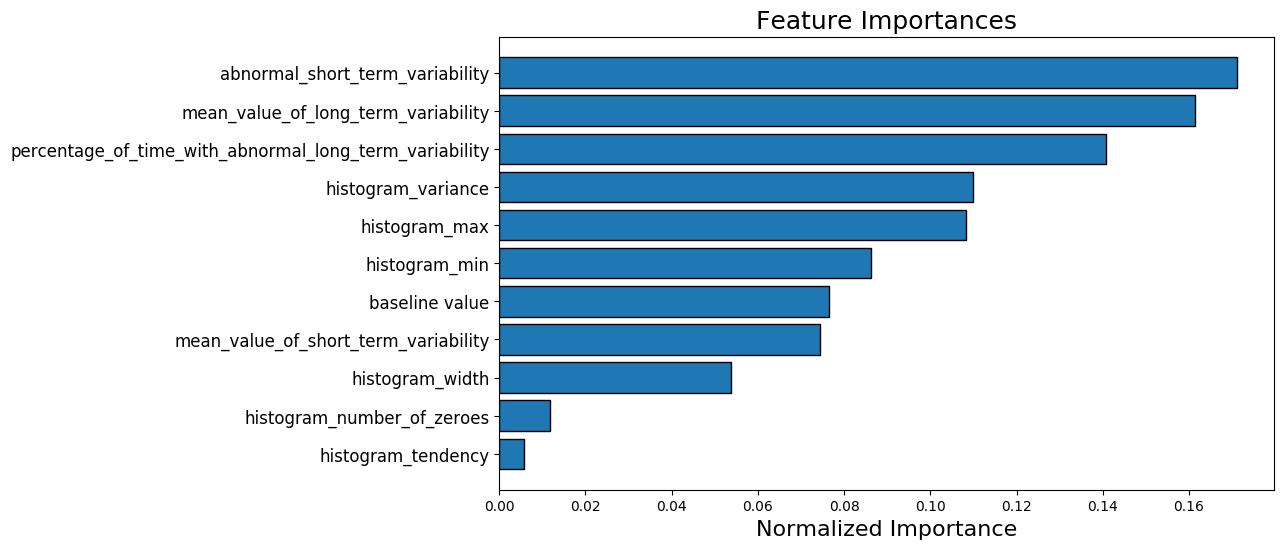

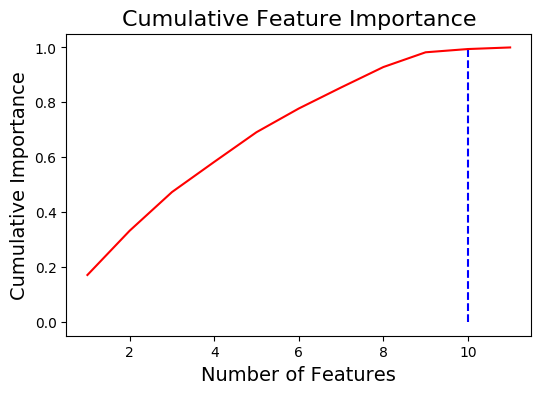

10 features required for 0.99 of cumulative importance


In [113]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 11)

##Removing Low Importance for Feature selection using Feature Selector
For this we first need to apply zero importance feature

In [118]:
fs.identify_low_importance(cumulative_importance = 0.99)

9 features required for cumulative importance of 0.99 after one hot encoding.
2 features do not contribute to cumulative importance of 0.99.



In [114]:
low_importance_features = fs.ops['low_importance']
low_importance_features

['histogram_number_of_zeroes', 'histogram_tendency']

In [115]:
all_to_remove = fs.check_removal()
all_to_remove

Total of 2 features identified for removal


['histogram_number_of_zeroes', 'histogram_tendency']

In [120]:
# We an keep one hot encoding = false to get the final df without ohe features but here we don't need it to keep false as only numerical columns are present.
X_train = fs.remove(methods = ['low_importance'])
X_test = fs.remove(methods= ['low_importance'])

Removed 2 features.
Removed 2 features.


In [117]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((1488, 9), (1488, 9), (1488,), (638,))

In [121]:
X_train.head()

,baseline value,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_variance
1178,126.0,25.0,1.4,0.0,6.3,48.0,107.0,155.0,9.0
408,150.0,76.0,0.2,43.0,5.2,35.0,123.0,158.0,1.0
802,146.0,65.0,0.4,33.0,7.4,30.0,134.0,164.0,1.0
22,128.0,34.0,2.5,0.0,4.0,145.0,54.0,199.0,148.0
204,120.0,51.0,0.7,15.0,7.4,21.0,109.0,130.0,0.0


In [123]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [145]:
print(Counter(y))

Counter({1.0: 1655, 2.0: 295, 3.0: 176})


In [147]:
nm = NearMiss(random_state=42)
X_nm, y_nm = nm.fit_sample(X,y)

In [149]:
X_nm.shape , y_nm.shape 

((528, 21), (528,))

In [151]:
print(Counter(y_nm))

Counter({1.0: 176, 2.0: 176, 3.0: 176})


##Applying Model

In [137]:
logistic = LogisticRegression(random_state=42)

In [164]:
random_parameters = ({'C' : [0.01, 0.1, 1.0],
                      'penalty' : ['l2'],
                      'multi_class' : ['ovr','multinomial'],
                      'solver' : ['lbfgs', 'newton-cg', 'saga'],
                      'max_iter' : [300,400,500,600,700,900,1000]})

random_search_logistic = RandomizedSearchCV(logistic, param_distributions= random_parameters, n_iter=100, cv=10)
random_search_logistic.fit(X_nm,y_nm)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'C': [0.01, 0.1, 1.0], 'penalty': ['l2'], 'multi_class': ['ovr', 'multinomial'], 'solver': ['lbfgs', 'newton-cg', 'saga'], 'max_iter': [300, 400, 500, 600, 700, 900, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [194]:
random_search_logistic.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [196]:
logistic = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                              intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
                              penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
                              verbose=0, warm_start=False)
logistic.fit(X_nm,y_nm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

recall_score is chosen because in this case recall is important because I want my model to predict more and more perfectly but in below model we can see that for class = 1, only 68% were correctly predicted out of actual.




In [197]:
logistic_y_pred = logistic.predict(X_nm)
print(classification_report(y_nm,logistic_y_pred))
print(confusion_matrix(y_nm,logistic_y_pred))
print(recall_score(y_nm, logistic_y_pred, average='macro'))

             precision    recall  f1-score   support

        1.0       0.82      0.68      0.74       176
        2.0       0.70      0.85      0.77       176
        3.0       0.89      0.84      0.87       176

avg / total       0.80      0.79      0.79       528

[[120  46  10]
 [ 18 150   8]
 [  9  19 148]]
0.7916666666666666


More focus was on using feature selection technique not on model application